In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg
from IPython.display import display, Math, Latex
import math # math module
from datetime import datetime
import EEG as tl
import re
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sc

In [6]:
data  = pd.read_csv('meditando.csv')
data2 = pd.read_csv('Jenny.csv')

In [28]:
canal1 = np.array(data['Dev1/ai0']*1000) #data canal 1 en mV
srate = 500
def sig_cut(signal,tstart,tlen,srate=500):
    n = len(signal)
    n_start = tstart*srate
    n_len = tlen*srate
    n_end = n_start+n_len
    cut = np.array([signal[i]for i in range(n_start,n_end)])
    return cut
signal= sig_cut(canal1,5,8)

In [29]:
eeg = np.array(data2['meditacion'])*1000 #registro EEG con 3 segundos de duración sr =500 hz
n_points = len(eeg)

# Defining functions

In [30]:
def SSA_r(signal, L):
    '''PREPARATION'''
    N = len(signal) #no. of points of signal
    K = N-L+1  #number of columns of matrix
    '''EMBEDDING'''
    X = np.array([[signal[i+j] for j in range(0,L)] for i in range(0,K)]) #Trajectory Matrix
    '''SVD'''
    Xh = X.transpose()
    S = np.matmul(Xh,X)
    U,s,V = linalg.svd(X)
    G = len(s)
    l = s**2 #Partial variances
    X_elem = []
    gkList = np.zeros(shape=(G,N))
    for k in range(0,G):
        Uk = U[:,k]
        Vk = V[k,:]
        X_k = s[k]*np.outer(Uk,Vk)
        X_elem.append(X_k)
        '''DIAGONAL AVERAGING'''
        gk = [] #list of values of time series
        for i in range(min(K-1,L-1),-max(K-1,L-1)-1,-1): # loop over diagonals
            gki=np.mean(np.diag(np.fliplr(X_k),i)) # successive time.series values
            gk.append(gki)
        gkList[k]=gk
#         for i in range(min(K-1,L-1),-max(K-1,L-1)-1,-1):
#             gki = np.mean(np.diag(np.fliplr(X_k),i))
#             gk.append(gki)
        gkList[k]=gk
    '''w-corr matrix'''
    w=[] # empty array to which to add successive weights
    LL=min(L,K)
    KK=max(L,K)
    for ll in range(1,LL+1): # first 1/3 part of weights
        w.append(ll)
    for ll in range(LL+1,KK+1): # second 1/3 part of weights
        w.append(LL)
    for ll in range(KK+1,N+1): # third 1/3 part of weights
        w.append(N-ll)
    kMin=kkMin=0 # show w-corr matrix for first 20 index values
    if L >= 20:
        kMax=kkMax=20
    else:
        kMax=kkMax=L
    #wMatriz=np.zeros(shape=(kMin,kMax)) # initial zero matrix  
    #for k in range(kMin,kMax):
        #for kk in range(kkMin,kkMax):
            #wMatriz[k][kk]=sum(w*gkList[k]*gkList[kk])/(math.sqrt(sum(w*gkList[k]*gkList[k]))*math.sqrt(sum(w*gkList[kk]*gkList[kk])))   
    wMatriz=[[sum(w*gkList[k]*gkList[kk])/(math.sqrt(sum(w*gkList[k]*gkList[k]))*math.sqrt(sum(w*gkList[kk]*gkList[kk]))) for k in range(kMin,kMax)] for kk in range(kkMin,kkMax)]
    wMatriz=np.array(wMatriz)
    return (G, l, gkList, wMatriz)

'''ScreeSSA function retrieved from Fossion,R.(2018)
Thank you Dr. Fossion! '''
def ScreeSSA(Serie,L): # 2 <= L <= N/2
    from scipy import linalg # linear algebra (matrix) processing package
    N=len(Serie)
    K=N-L+1
    X=np.array([[Serie[i+j] for j in range(0,L)] for i in range(0,K)]) # trajectory matrix
    s=linalg.svd(X,compute_uv=False) # descomposición en valores singulares 
    l=s**2 # partial variances
    return l;    
def mapping(series, L,N_comp):
    r,l,gklist,wMatrix = SSA_r(series,L)
    N = len(series)
    X = np.zeros((N_comp,N))
    for i in range(N_comp):
        for j in range(N):
            X[i][j] = gklist[i][j]
    T = 1/500
    X_j = 2.0/N * np.abs(sc.fft.fft(X)[0:N//2,0:N//2] )
    X_freq = sc.fft.fftfreq(N, T)[:N//2]
    return X_j,X_freq
def energy(series_fft,freq,fi,ff):
    E = 0
    f_int = freq[1]-freq[0]
    fi_index = int(fi/f_int)
    ff_index = int(ff/f_int)
    series_e = abs(series_fft)**2
    for i in range(fi_index,ff_index):
        E = E + series_e[i]
    return E

In [575]:
N = len(eeg)
T = 1/500
Signal_energy = energy(2.0/N * np.abs(sc.fft.fft(eeg)[0:N//2] ),sc.fft.fftfreq(N, T)[:N//2],0,250)
L = 83
N_comp=10
tin=datetime.now()
print('Time @ start =',str(datetime.now()))
r,l,gklist,wMatrix = SSA_r(eeg,L)
tfin = datetime.now()
print('Time @ end =',str(datetime.now()))
delta = tfin-tin
sec,milisec = re.findall('\d+',str(delta))[2],re.findall('\d+',str(delta))[3]
print(f'SSA decomposition completed! It only took {sec} sec with {milisec} milisec!')

Time @ start = 2021-06-07 15:08:46.755982
Time @ end = 2021-06-07 15:08:49.977162
SSA decomposition completed! It only took 03 sec with 221180 milisec!


In [590]:

for j in np.arange(10,100,10):
    L_l=j
    N_comp = 6
    X_j , X_freq = mapping(eeg,L_l,N_comp)
    fig = plt.figure(figsize=(30,15))
    ax = fig.add_subplot(1,1,1,projection='3d')
    for i in range(0,N_comp):
        E = energy(X_j[i][0:150],X_freq[0:150],0,50)
        percento = round((E/Signal_energy)*100,2)
        ax.plot(X_freq[0:150],np.ones(len(X_freq[0:150]))*(i+2),X_j[i][0:150],label=f'$C_{i+1}$, $E ={round(E,2)}J$, {percento}%')
        ax.set_title(f'FFT en $L = {L_l}$,$N_c ={N_comp-1}$')
        plt.legend()
    # ax.invert_yaxis()
    # Customize the axis.
    # ax.set_zlim(0, 5)
    ax.set_xlim(0,50)
    ax.set_zlabel('Potencia')
    # #Axes labels
    ax.set_xlabel('Frecuencia [Hz]')
    ax.set_ylabel('Componente')
    # ax.yaxis.set_ticks(np.arange(2, n_comp, 1))
    # rotate the axes and update
#     for angle in range(0, 360):
#        ax.view_init(30, angle)
    plt.show()

In [574]:
L_i=10
L_f=20
L_step=2
n_comp=5
def Gen_FFTcurves(L,n_comp,series=eeg):
    X_j , X_freq = mapping(eeg,L,n_comp)
    X_freq_cut = X_freq[0:150].tolist()
    fulldata=[]
    for i in range(n_comp):
        Z = X_j[i][0:150].tolist()
        Y_comp = np.ones(len(X_freq[0:150]))*(i+1)
        curvedata= np.array([X_freq_cut,Y_comp.tolist(),Z])
        fulldata.append(curvedata)
    fulldata= np.array(fulldata)
    return fulldata
data_of_data = [Gen_FFTcurves(l,n_comp) for l in np.arange(L_i,L_f,L_step)]
x1=[]
d = {}
for x in range(1, n_comp):
    d["z{0}".format(x)] = []
f = {}
for x in range(1, n_comp):
    f["y{0}".format(x)] = []
    
def plot_curves(w):
    for x in range(1,n_comp):
        d['z{0}'.format(x)]=data_of_data[w][x][2]
        f['y{0}'.format(x)]=data_of_data[w][x][1]
    x1=data_of_data[w][x][0]
    for i in range(1,n_comp):
        
        z = d['z{0}'.format(i)]
        y = f['y{0}'.format(i)]

        ax.plot(x1,y,z,label=f'$L={w},C={i}$')
    return

#Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

#Setting the axes properties
ax.set_xlim(0,50)
ax.set_zlabel('Potencia')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Componente')
ax.set_title(f'Espectro de Fourier variando $L$')
# Creating the Animation object
ani = animation.FuncAnimation(fig, plot_curves,interval=500, blit=False,repeat=True)
plt.show()

In [ ]:
%matplotlib qt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib as mpl

fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(X,Y,X_j[0:150,0:150],s=5,c=np.arange(3000))
ax.invert_yaxis()
# Customize the axis.
# ax.set_zlim(0, 5)
ax.set_xlim(0,50)
ax.set_zlabel('Potencia')
# #Axes labels
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Componente')
ax.yaxis.set_ticks(np.arange(1, n_comp, 2))

# rotate the axes and update
for angle in range(0, 360):
   ax.view_init(30, angle)


plt.show()

In [572]:
len(np.arange(10,50,5))

8

In [3]:
open_dat = pd.read_csv('open-closedat.csv')
eeg_c = open_dat['Dev1/ai0'].to_numpy()
ecg_c = open_dat['Dev1/ai1'].to_numpy()

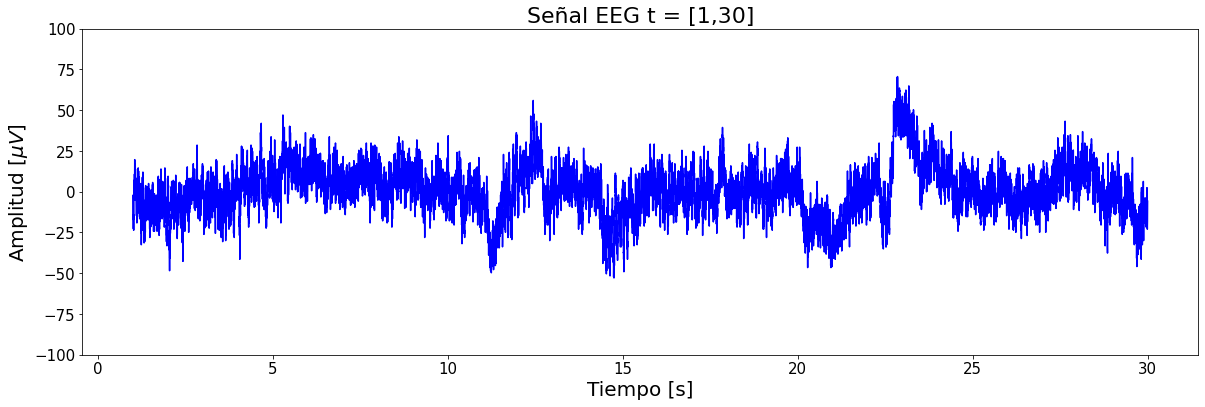

In [63]:
import EEG as tl
import re
tl.eeg_plot(eeg_c*1000,1,30,-100,100)

In [64]:
%matplotlib inline
tint = 3
eyes1 = sig_cut(eeg_c,5,tint)*1000
eyes2 = sig_cut(eeg_c,15,tint)*1000
n_points = len(eyes)
time=np.linspace(0,tint,n_points)

In [91]:
%matplotlib qt
probe=eyes2
N = len(probe)
T = 1/500
Signal_energy = energy(2.0/N * np.abs(sc.fft.fft(probe)[0:N//2] ),sc.fft.fftfreq(N, T)[:N//2],0,250)
for j in np.arange(10,100,10):
    L_l=j
    N_comp = 6
    X_j , X_freq = mapping(probe,L_l,N_comp)
    fig = plt.figure(figsize=(30,15))
    ax = fig.add_subplot(1,1,1,projection='3d')
    for i in range(0,N_comp):
        E = energy(X_j[i][0:150],X_freq[0:150],0,50)
        percento = round((E/Signal_energy)*100,2)
        ax.plot(X_freq[0:150],np.ones(len(X_freq[0:150]))*(i+2),X_j[i][0:150],label=f'$C_{i+1}$, $E ={round(E,2)}J$, {percento}%')
        ax.set_title(f'FFT en $L = {L_l}$,$N_c ={N_comp-1}$ en Ojos2')
        plt.legend()
    # ax.invert_yaxis()
    # Customize the axis.
    # ax.set_zlim(0, 5)
    ax.set_xlim(0,50)
    ax.set_zlabel('Potencia')
    # #Axes labels
    ax.set_xlabel('Frecuencia [Hz]')
    ax.set_ylabel('Componente')
    # ax.yaxis.set_ticks(np.arange(2, n_comp, 1))
    # rotate the axes and update
#     for angle in range(0, 360):
#        ax.view_init(30, angle)
    plt.show()

Time @ start = 2021-06-16 11:39:48.399695
Time @ end = 2021-06-16 11:39:49.531045
SSA decomposition completed! It only took 01 sec with 132350 milisec!


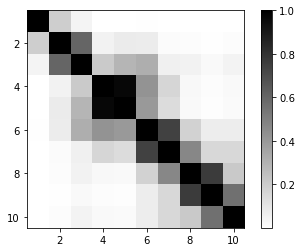

In [76]:
%matplotlib inline
L_l = 20
N_comp=10
tin=datetime.now()
print('Time @ start =',str(datetime.now()))
r,l,gklist,wMatrix = SSA_r(eyes1,L_l)
tfin = datetime.now()
print('Time @ end =',str(datetime.now()))
delta = tfin-tin
sec,milisec = re.findall('\d+',str(delta))[2],re.findall('\d+',str(delta))[3]
print(f'SSA decomposition completed! It only took {sec} sec with {milisec} milisec!')
x=np.arange(1, N_comp, 2)
y=x+1
plt.imshow(wMatrix[0:N_comp,0:N_comp],cmap=plt.cm.binary);
plt.colorbar()
plt.xticks(x,y)
plt.yticks(x,y)
plt.show()

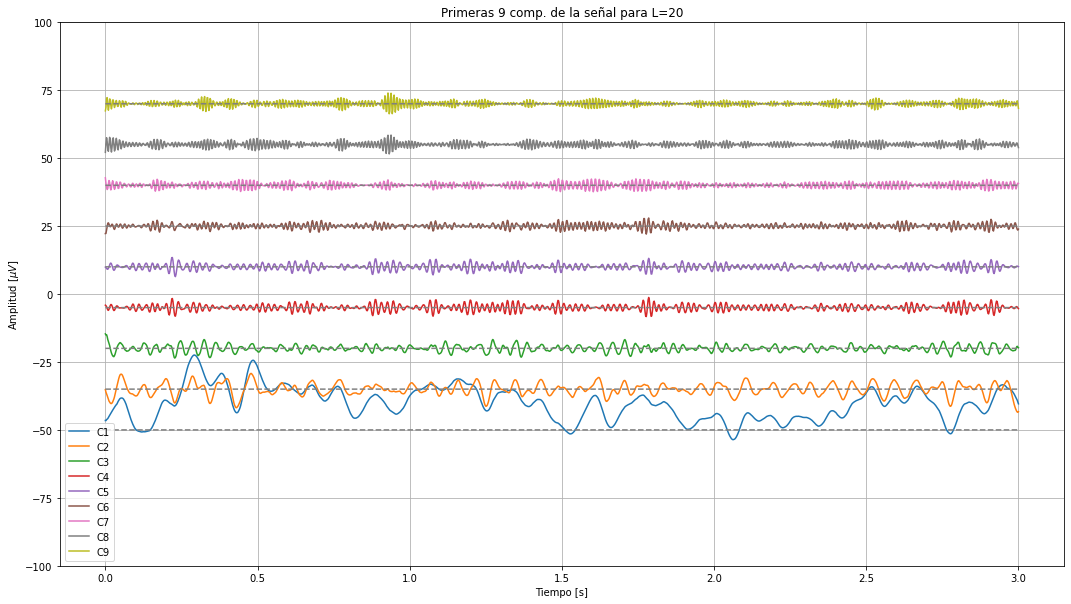

In [77]:
fig,ax = plt.subplots(1,1,figsize=(18,10))
for i in range (9):
    ax.plot(time,gklist[i]-50+i*15,label=f'C{i+1}')
    ax.plot(time,np.ones(1500)*(-50)+(i*15),'--',c='gray')
    ax.set_xlabel('Tiempo [s]')
    ax.set_ylabel('Amplitud [$\mu V$]')
    ax.set_title(f'Primeras {N_comp-1} comp. Ojos1 para L={L_l}')
    ax.set_ylim(-100,100)
ax.legend()
ax.grid()
plt.savefig(f'SSA/Results/Prueba ojos1 {N_comp-1}comp-L={L_l}.jpeg', dpi=300)

In [87]:
# %matplotlib inline
import wavelets as wv
fi = 1 #frecuencia inicial
ff = 50 #frecuencia final
resf = 1 #resolución espectral
time_s = 3 #tiempo en segundos de la señal
fig,ax = plt.subplots(1,1,figsize=(20,5))


T_WD = wv.MRA(eyes1,fi,ff,resf,wv.morlet,500)
ax.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo')
ax.set_xlabel('Tiempo[s]')
ax.set_ylabel('Frecuencia[Hz]')
ax.set_title(r'$|\mathcal{X}(f)|^2 \{ Y_N \}$ Ojos 1')
fig.colorbar(plt.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo'))
ax.invert_yaxis()
plt.show()

Time @ start = 2021-06-16 11:39:57.244898
Time @ end = 2021-06-16 11:39:58.423183
SSA decomposition completed! It only took 01 sec with 178285 milisec!


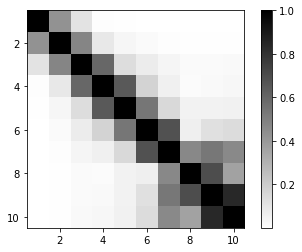

In [78]:
%matplotlib inline
L_l = 20
N_comp=10
tin=datetime.now()
print('Time @ start =',str(datetime.now()))
r,l,gklist,wMatrix = SSA_r(eyes2,L_l)
tfin = datetime.now()
print('Time @ end =',str(datetime.now()))
delta = tfin-tin
sec,milisec = re.findall('\d+',str(delta))[2],re.findall('\d+',str(delta))[3]
print(f'SSA decomposition completed! It only took {sec} sec with {milisec} milisec!')
x=np.arange(1, N_comp, 2)
y=x+1
plt.imshow(wMatrix[0:N_comp,0:N_comp],cmap=plt.cm.binary);
plt.colorbar()
plt.xticks(x,y)
plt.yticks(x,y)
plt.show()

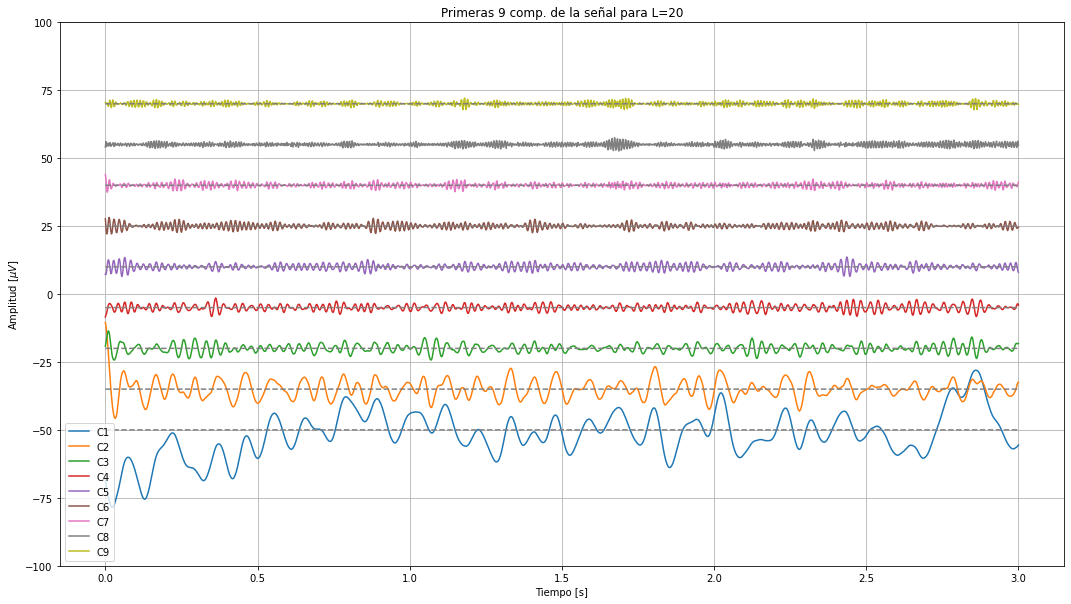

In [79]:
fig,ax = plt.subplots(1,1,figsize=(18,10))
for i in range (9):
    ax.plot(time,gklist[i]-50+i*15,label=f'C{i+1}')
    ax.plot(time,np.ones(1500)*(-50)+(i*15),'--',c='gray')
    ax.set_xlabel('Tiempo [s]')
    ax.set_ylabel('Amplitud [$\mu V$]')
    ax.set_title(f'Primeras {N_comp-1} comp. Ojos2 para L={L_l}')
    ax.set_ylim(-100,100)
ax.legend()
ax.grid()
plt.savefig(f'SSA/Results/Prueba ojos2{N_comp-1}comp-L={L_l}.jpeg', dpi=300)

In [88]:
fi = 1 #frecuencia inicial
ff = 50 #frecuencia final
resf = 1 #resolución espectral
time_s = 3 #tiempo en segundos de la señal
fig,ax = plt.subplots(1,1,figsize=(20,5))


T_WD = wv.MRA(eyes2,fi,ff,resf,wv.morlet,500)
ax.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo')
ax.set_xlabel('Tiempo[s]')
ax.set_ylabel('Frecuencia[Hz]')
ax.set_title(r'$|\mathcal{X}(f)|^2 \{ Y_N \}$ Ojos 2')
fig.colorbar(plt.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo'))
ax.invert_yaxis()
plt.show()